# Visualizing Data in Roman ASDF Files

***

## Kernel Information

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.

## Imports
- *astropy.visualization.simple_norm* for automatically scaling image arrays
- *astropy.coordinates.SkyCoord* to create Python objects containing sky coordinate transforms
- *matplotlib.pyplot* for creating static image previews
- *jdaviz.Imviz* to examine Wide Field Instrument (WFI) images interactively
- *roman_datamodels* for opening Roman WFI ASDF files
- *asdf* for opening Roman WFI ASDF files
- *time* for creating pauses in the notebook cells

In [1]:
%matplotlib inline
from astropy.visualization import simple_norm
from astropy.coordinates import SkyCoord
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

from jdaviz import Imviz
import roman_datamodels as rdm
import asdf
import s3fs
import time

## Introduction
In this tutorial, we demonstrate how to visualize and explore Roman WFI image data arrays. We separate this tutorial into two high-level components:
1. creating static images with world coordinate system (WCS) overlays; and
2. using the Jdaviz tool to interactively explore WFI image data.

We focus on how to visualize WFI Level 2 (L2; calibrated rate image) data in ASDF format. For WFI, L2 indicates that the data have been processed to flag and/or correct for detector-level effects (e.g., saturation, classic non-linearity, etc.) and the resultants fitted into a count rate image. Each L2 ASDF file contains a single WFI detector, thus a complete WFI exposure is made up of 18 L2 files. For more information WFI L2 files, please see the RDox article on [Data Levels and Products](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/data-levels-and-products#DataLevelsandProducts-Level2-CalibratedExposuresLevel2).

***

## Loading data
We use the same data file in both examples. Note that the static image portions can be used on any `numpy.ndarray` object, and the WCS axes may be optionally included with any `astropy.wcs.WCS` object. Also, while the Jdaviz example is designed to work on Roman data, Jdaviz can also work with other data and file types. A link to the Jdaviz documentation is provided in the Additional Resources section below.

A complete explanation on how to load and work with Roman ASDF files is provided in the notebook tutorial [Working with ASDF](../working_with_asdf/working_with_asdf.ipynb). We read in the data using the `roman_datamodels` package:

In [2]:
asdf_dir_uri = 's3://roman-sci-test-data-prod-summer-beta-test/'
fs = s3fs.S3FileSystem()

asdf_file_uri = asdf_dir_uri + 'AAS_WORKSHOP/r0003201001001001004_0001_wfi01_f106_cal.asdf'
with fs.open(asdf_file_uri, 'rb') as f:
    af = asdf.open(f)
    file = rdm.open(af).copy()

## Static Image Display

### Plot an Image with Dynamic Scaling

Here we show how to use matplotlib and Astropy to plot the data array from our WFI image and scale the array automatically.

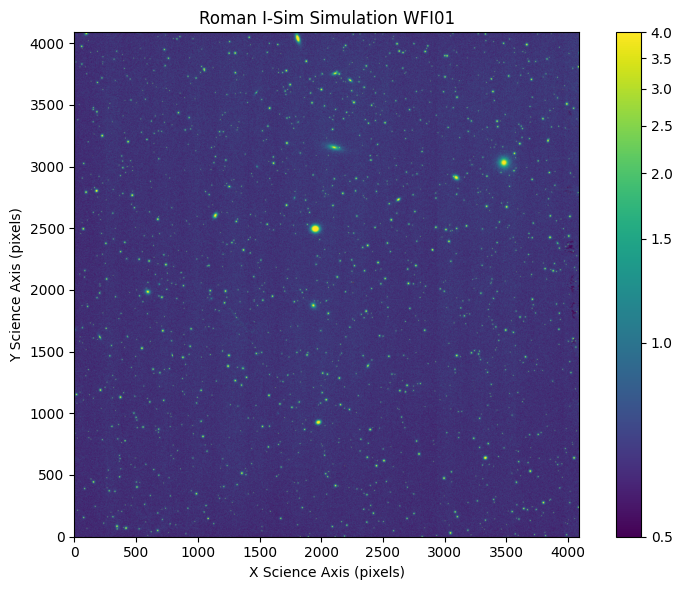

In [3]:
# Set the image normalization. Here we use a log scale 
# with the minimum and maximum of the range based on 
# 99% of the pixels.
norm = simple_norm(file.data, 'asinh', vmin=0.5, vmax=4)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.imshow(file.data, norm=norm, origin='lower')
ax.set_xlabel('X Science Axis (pixels)')
ax.set_ylabel('Y Science Axis (pixels)')
ax.set_title('Roman I-Sim Simulation WFI01')
plt.colorbar(sc, ax=ax)
plt.tight_layout();

We can see a bright, extended source in the lower portion of the image. We isolate and examine that region a little more closely. Looking at the output image above, we can see that it is located approximately between science Y coordinates 3000 – 3500 and science X coordinates 1750 - 2250.

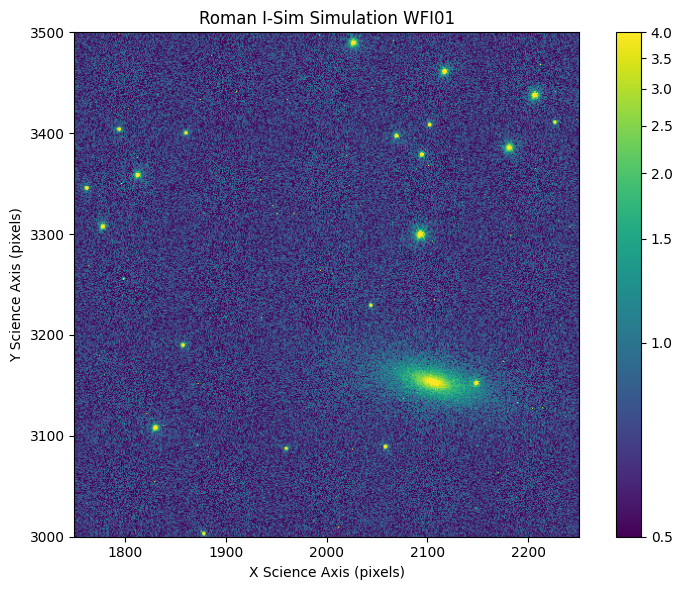

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.imshow(file.data, norm=norm, origin='lower')
ax.set_xlabel('X Science Axis (pixels)')
ax.set_ylabel('Y Science Axis (pixels)')
ax.set_title('Roman I-Sim Simulation WFI01')
ax.set_xlim(1750, 2250)
ax.set_ylim(3000, 3500)
plt.colorbar(sc, ax=ax)
plt.tight_layout();

If we want to add information about the sky coordinates rather than displaying the image in pixels, we can use the `gwcs.wcs.WCS` object in the file metadata.

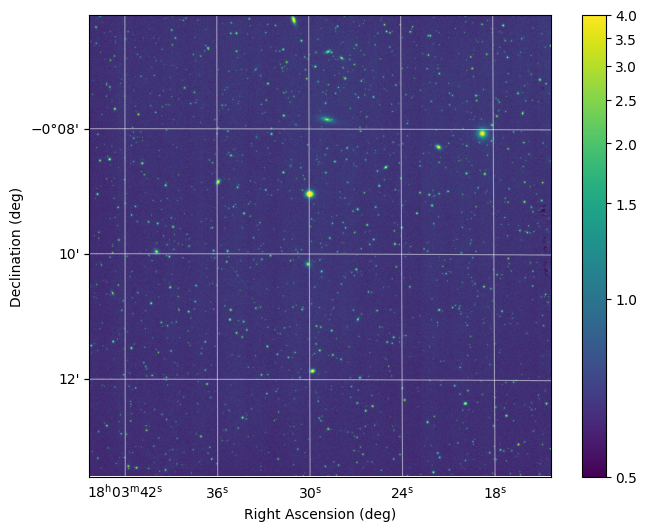

In [5]:
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': file.meta.wcs})
sc = ax.imshow(file.data, norm=norm, origin='lower')
ax.grid(':', color='white', alpha=0.5)
plt.colorbar(sc, ax=ax)
ax.set_xlabel('Right Ascension (deg)')
ax.set_ylabel('Declination (deg)');

## Interactively Examine the Data Using Imviz

### Introduction and Setup

We can also use Imviz, the 2-D image viewer from the Jdaviz package, to visualize and explore the 2-D arrays contained within WFI L2 ASDF files. We highly recommend that users consult the [Imviz documentation](https://jdaviz.readthedocs.io/en/latest/imviz/index.html), which describes many of the features in Imviz in detail. In this tutorial, we will cover the basics to get you started.

**Note:** An enhancement to Cubeviz, the 3-D datacube visualization tool in Jdaviz, will soon allow interactive exploration of WFI L1 data cubes. This functionality is currently being tested and will be available in a future Jdaviz release.

The first cell below loads Imviz and creates a split panel to the right. You can control the height, or use a pop out window or an inline viewer. For more information, please see the [display options](https://jdaviz.readthedocs.io/en/latest/display.html) documentation.

In [12]:
imviz = Imviz()
imviz.show('sidecar', height=1000)

**Note:** You may need to expand the Imviz window to see all of the menubar items. You can also minimize the viewer by clicking on the tab on the far-right of your browser that says "imviz." Clicking the "x" symbol next to it will close the tab, but clicking on the word "imviz" will hide the viewer until it is clicked again.

### Loading Data and Programmatically Adjusting Display

Next, we load the image into Imviz. By default, for Roman WFI data, Imviz only loads the data array in the viewer to improve performance. Additional arrays (e.g., the data quality array) may be loaded using the `ext` optional argument. An example demonstrating how to load the data quality array is provided in a commented line in the following cell. For more information on the arrays contained within WFI L2 files, please see the RDox article on WFI [Data Levels and Products](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/data-levels-and-products#DataLevelsandProducts-L2ScienceDataSpecifications).

**Note:** We have added a few pauses in the notebook cells with, e.g., `time.sleep(5)`, which should cause the cell to pause for several seconds before completing. This is to ensure that the previous cell has had enough time to complete its tasks before moving on to the next step. These pauses may make Imviz feel a little slow, but it is meant to slow you down so you don't try to issue new commands before the previous ones finish executing.

In [13]:
asdf_dir_uri = 's3://roman-sci-test-data-prod-summer-beta-test/'
fs = s3fs.S3FileSystem()

asdf_file_uri = asdf_dir_uri + 'AAS_WORKSHOP/r0003201001001001004_0001_wfi01_f106_cal.asdf'
with fs.open(asdf_file_uri, 'rb') as f:
    af = asdf.open(f)
    file = rdm.open(af)
    imviz.load_data(file, data_label='WFI01_POS1')
    # imviz.load_data(file, ext='dq', data_label='WFI01 DQ')

time.sleep(10)

The colormap, stretch, and scale limits may be adjusted interactively in the viewer by clicking the plot options icon (three vertically-stacked sliders to the far right of the teal bar above the image display, hereafter the "tool bar"), and expanding the "Plot Options" section. Note that there are additional options such as the minimum and maximum scale limits under the "More Stretch Options" expander.

If we know the settings we want to apply, we can do so via the API as follows:

In [14]:
viewer = imviz.default_viewer
viewer.stretch_options
viewer.stretch = 'arcsinh'
viewer.set_colormap('Viridis')
viewer.cuts = (0.5, 4)
time.sleep(5)

Now we will display a second image, showing the same field but slightly dithered, and we will link the two images by their WCS. The second image is dithered by ~200 arcseconds compared to the first, so sources should move by ~1000 pixels between the two images. This is easy to observe with the galaxy in the bottom-left quadrant of the first image, which is located in the bottom-middle of the second image.

In [15]:
asdf_file_uri = asdf_dir_uri + 'AAS_WORKSHOP/r0003201001001001004_0002_wfi01_f106_cal.asdf'
with fs.open(asdf_file_uri, 'rb') as f:
    af = asdf.open(f)
    file = rdm.open(af)
    imviz.load_data(file, data_label='WFI01_POS2')

viewer = imviz.default_viewer
viewer.stretch_options
viewer.stretch = 'arcsinh'
viewer.set_colormap('Viridis')
viewer.cuts = (0.5, 4)

Now that the second image has been displayed, we can blink between the two using the "b" button. Make sure that your cursor is placed over the image to make it the active window, then blink between the images.

Similarly to our matplotlib demonstration, let's investigate a region of interest and focus on the large extended source in the lower portion of the image. In this case, we know the galaxy has science pixel coordinates of (X, Y) ~ (3100, 2000) pixels or sky coordinates of (RA, Dec) ~ (270.86998, -0.131080) degrees. This information can be determined from the catalog used to simulate the products, or may come from interactive examintion of the image or a source detection algorithm. Regardless of how we obtained the coordinates, we can center the viewer on them using the API as shown below:

In [16]:
# Center the image on given sky coordinates.
sky = SkyCoord(ra=270.86998, dec=-0.131080, unit=('deg', 'deg'))
viewer.center_on(sky)

# Center the image on given pixel coordinates.
# viewer.center_on((3100, 2000))

time.sleep(5)

We can also set the zoom level to better display the region around the extended source. The zoom level settings are such as:
* 1: real-pixel-size.
* 2: zoomed in by a factor of 2.
* 0.5: zoomed out by a factor of 2.
* 'fit' means zoomed to fit the whole image into display.

In this case, we will set the zoom level to 0.4 so we can see the extended source in both images and blink between them. Recall that to blink the images, you need to place the cursor over the viewer and press the "b" key on your keyboard.

In [17]:
viewer.zoom_level = 0.4
time.sleep(5)

As you can see, when blinking the images in detector coordinates, the sources seem to move because the second image is slightly dithered. If we link the images by their WCS information, we see that the sources remain fixed, but the regions of the sky observed are slightly different.

**Note:** Roman WFI ASDF files use a Generalized World Coordinate System (gwcs) object in Python to store the WCS transformation. The transformation is only well-defined within a bounding box, and moving outside that bounding box produces unexpected behavior, particularly due to the polynomial terms in the transformation between pixel and sky coordinates. As a result, the current version of Imviz might have some difficulties with setting a position and zooming after linking the images by WCS.

In [18]:
orientation = imviz.plugins['Orientation']
orientation.align_by = 'WCS'
time.sleep(5)

You can also save the current view to a PNG file on your cloud storage:

In [19]:
viewer.save('my_image.png')
time.sleep(5)

This should save the file to your current working directory on the the science platform. If you want to download this file, you can do so by right-clicking on the file in the file browser and selecting the "Download" option.

### Overlaying Catalog Data

First, let's read in the catalog used to generate this image using Roman I-Sim:

In [20]:
# Read in catalog data from S3
cat_uri = asdf_dir_uri + 'AAS_WORKSHOP/full_catalog.ecsv'
with fs.open(cat_uri, 'rb') as f:
    tab = Table.read(f, format='ascii.ecsv')

There are a lot of sources in this file, but let's pare them down somewhat for display purposes. In this case, let's filter down to the brightest ($m_{AB}$ < 18) sources in the F106 filter. The flux columns in the table are in units of maggies, which may be converted to AB magnitudes as $m_{AB} = -2.5\log_{10}(f)$ where $m_{AB}$ is the magnitude in AB mags and $f$ is the flux in maggies.

In [21]:
# Create SkyCoord objects
bright = np.where(-2.5 * np.log10(tab['F106']) < 18)
coords = Table({'coord': [SkyCoord(ra = tab['ra'][bright], dec = tab['dec'][bright], unit = 'deg')]})

Now let's set up the markers and add them to the viewer:

In [22]:
# Set up viewer marker parameters
viewer.marker = {'color': 'white', 'alpha': 0.8, 'markersize': 120, 'fill': False}

# Overlay markers
viewer.add_markers(coords, use_skycoord=True, marker_name='My_Markers')
time.sleep(5)

We can also remove them if we don't want them any longer, or if we want to replace them with other markers:

In [23]:
# Remove only My_Markers
viewer.remove_markers(marker_name='My_Markers')

# Remove ALL markers
# viewer.reset_markers()

For more advanced use cases such as interactive aperture photometry or analysis of line profiles, please consult the [Imviz documentation](https://jdaviz.readthedocs.io/en/latest/imviz/index.html).

## Aditional Resources

- [Imviz Documentation](https://jdaviz.readthedocs.io/en/latest/imviz/index.html)
- [Additional JDaviz Notebooks](https://github.com/spacetelescope/jdaviz/tree/main/notebooks)
- [RDox WFI Data Levels and Products](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/data-levels-and-products#DataLevelsandProducts-L2ScienceDataSpecifications)

## About this notebook
**Author:** Tyler Desjardins, Brett Morris  
**Updated On:** 2024-01-09

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 